# Acceleration Data Processor Type B

## How to use
1. Make sure all the required packages are installed
    * Run the following command to install if you haven't: ```pip install pandas matplotlib xlrd scipy notebook```
2. If you are seeing this, you are already running jupyter notebook
3. To run this program, navigate to:
    1. Menu Bar >
    2. Kernel >
    3. Restart & Run All
4. Follow the prompts at the bottom of this notebook

# 1) Import modules

In [1]:
import pandas as pd
import csv
import os.path
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# 2) Formatting the specified raw data provided in .csv format 

## Auxiliary Functions

```getInputForColumns()```
Returns a list with column ids as Strings.
    
The elements are column ids in A1 format and are set as follows:\
[Time-stamp, Acceleration X, Acceleration Y, Accelerationz]

Function parameters:\
None

In [2]:
def getInputForColumns():
    """Returns a list with column ids as Strings.
    
    The elements are column ids in A1 format and are set as follows:
    [Time-stamp, Acceleration X, Acceleration Y, Acceleration Z]
    """
    
    # Get input for the columns
    interval = 0
    startIndex = 0
    column_ids = ["", "", "", ""]
    buffer = ""
    isFinal = False
    
    while (isFinal == False):
        print("Enter the row number to start data input (0 for the first row): ")
        startIndex = int(input("Start Index: "))
        print("Enter the row interval for acceleration (if each row is the reading for acceleration, just enter 1): ")
        interval = int(input("Row Interval: "))
        print("Enter the Column ID in A1 format (e.g. A, B, C) for the following items:")
        buffer = input("Time-stamp: ")
        column_ids[0] = buffer
        buffer = input("Acceleration X: ")
        column_ids[1] = buffer
        buffer = input("Acceleration Y: ")
        column_ids[2] = buffer
        buffer = input("Acceleration Z: ")
        column_ids[3] = buffer
        buffer = input("Confirm entry? [Y]/[N]: ")
        if (buffer.lower() == "y"):
            isFinal = True
    
    return startIndex, interval, column_ids

```a1ToIndex```
Converts the Supplied Column ID in A1 format to a Normal Index starting from 0
    
Function parameters:\
(String) a1 -- Column ID in String Format

In [3]:
def a1ToIndex(a1, isZeroIndex):
    """Converts the Supplied Column ID in A1 format to a Normal Index starting from 0
    
    Function parameters:
    (String) a1 -- Column ID in String Format
    """
    assert type(a1) is str, "Expected a String"
    assert type(isZeroIndex) is bool, "Expected a Boolean"
    from openpyxl.utils import column_index_from_string
    return column_index_from_string(a1) - int(isZeroIndex)*1

## Filters, Creates new csv, and Converts to Pandas Data Frames

|**Parameter**|**Description**|**Variable Used**|**Description**|
|:-|:-|:-|:-|
|```file_name```|the name of the file (in string)|```formatted```|the csv file generated and one where filtering is applied to|
|```title```|name of the file|```df```|the DataFrame generated from the formatted csv file|
|```output_path```|the path for output| |


In [4]:
def csv2df(file_name, title, output_path):
    '''filter the csv file & import to DataFrame'''
    formatted_output_path = output_path + "/" + title + "-formatted.csv"
    
    # Get the column ids where the required data is located from the user
    startIndex, interval, column_ids = getInputForColumns()
    # Transform the user input in A1 format into index for use later
    # [0: Time-stamp, 1: Acceleration X, 2: Acceleration Y, 3: Acceleration Z]
    column_indexes = [a1ToIndex(colID, True) for colID in column_ids]
    
    # Opens the given file
    my_file = open(file_name)
    
    # Creates a clean csv file for output
    formatted = open(formatted_output_path,"w",newline='')
    
    # Sets this as csv
    reader = csv.reader(my_file)
    formatted_csv = csv.writer(formatted)
    
    # Create a header in formatted.
    header = ['TimeStamp','TimeElapsed','Category','Acc-X','Acc-Y','Acc-Z']
    formatted_csv.writerow(header)
    
    # Start filtering
    i = 0 #initial value for the index, used for mapping
    for item in reader:
        if ((i-startIndex) >= 0) & (((i - startIndex) % interval) == 0):
            each_line = []
            for column_index in column_indexes:
                each_line.append(item[column_index])
            each_line.insert(1,0)
            each_line.insert(2,"Acceleration")
            formatted_csv.writerow(each_line)
            i += 1
        else:
            i += 1
            
    # Closes the given file
    my_file.close()
    
    # Change to Dataframe in pandas
    df = pd.read_csv(formatted_output_path,header = 0)   

    return df

# 3) DataFrame Manipulation

## Function to remove data for when train is stationary

In [5]:
def truncateStationaryValues(df):
    # Currently using a rolling average n of 5. Hence the use of "3" as the start index in range.
    # You can change the n to any odd number. If you choose "3", then the start index will be 1 and the end index will be 1.
    # Might consider doing this automatically later
    
    threshold = 0.02 # Change threshold here
    
    from copy import deepcopy
    
    acc_data = deepcopy(df.iloc[0:len(df),4].tolist())
    for i, e in enumerate(acc_data):
        acc_data[i] = -e*9.81 # This does not respect the option for 
    
    j = 3
    rolling_avg_prev = (acc_data[j-2] + acc_data[j-1] + acc_data[j] + acc_data[j+1] + acc_data[j+2])/5
    rolling_avg_cur = 0
    truncate_index = 0
    
    for i in range(3, len(df) - 3):
        rolling_avg_cur = (acc_data[i-2] + acc_data[i-1] + acc_data[i] + acc_data[i+1] + acc_data[i+2])/5
        delta = rolling_avg_cur - rolling_avg_prev
        if (delta > threshold):
            # print(i, delta, acc_data[i]) # For debugging
            truncate_index = i
            break
    
    rowsToTruncate = [idx for idx in range(0, truncate_index)]
    df = df.drop(rowsToTruncate)
    return df

## Function to Generate Time Elapsed

In [6]:
def timeElapsed(df, TimestampInMs): 
    # Calculate and write a time_elapsed column
    
    startTime = df.iloc[0,0]
    if (TimestampInMs):        
        for i in range(len(df)):
            df.iloc[i,1]=(df.iloc[i,0]-startTime)/(1000)
    else:
        for i in range(len(df)):
            df.iloc[i,1]=(df.iloc[i,0]-startTime)


## Function to Generate Time Interval

In [7]:
def timeInterval(df):
    '''calculate time interval from the TimeElpased colomn'''
    
    #index of TimeInterval: 6
    timeInterval = [0]
    for i in range (1,len(df)):
        timeInterval.append(df.iloc[i,1]-df.iloc[i-1,1])
        
    df["TimeInterval"]=timeInterval

## Function to generate Acc-Y-Adjusted

Variable: <br>
shift_value: the value to shift all acceleration values 
<p> in this application, the shift value from the experiment results, is approximately to be (initial accelration)/2</p>

In [8]:
def accAdjust(df):
    '''Generate the Acc-Y-Adjusted and take the shift value into account'''
    
    # Column index of Acc-Y-Adjusted: 7
    
    # Make a copy of the acc-y data and store it in acc_Y
    # While doing so, change the data from a "g" based value to a ms^(-2) value
    acc_Y = []
    for i in range(len(df)):
        acc_Y.append(-df.iloc[i,4]*9.8)
        
    # Filter to remove noise
    # Use the previous adjusted values in acc_Y
    n = 15  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n # b, numerator coefficient vector in a 1-D sequence
    a = 1 # a, denominator coefficient vector in a 1-D sequence
    acc_Y_filtered = lfilter(b,a,acc_Y)
    
    # Set final filtered data to equal column "Acc-Y-Adjusted"
    df["Acc-Y-Adjusted"] = acc_Y_filtered
    
    # Shift the data by a set value
    # Crude method by finding the mean of entire dataset
    
    shift_value = df["Acc-Y-Adjusted"].mean()

    for i in range(len(df)):
        df.iloc[i,7] = df.iloc[i,7] - shift_value


## Function to generate V-btw2

In [9]:
def dv(df):
    '''Generate the d_v using the definition of integration using the Acc-Y-Adjusted values'''
    
    #index of V-btw2: 8
    d_v = [0]
    for i in range (1,len(df)):
        velocity_each = 0.5*(df.iloc[i,7]+df.iloc[i-1,7])*df.iloc[i,6] #index7: Acc-Y-Adjusted, index6: TimeInterval
        d_v.append(velocity_each)
    
    df["V-btw2"]=d_v

## Function to generate V(t)

In [10]:
def vt(df):
    '''Generate the v(t) colomn to record the instantanious velocity in any data point'''
    
    #index of V(t): 9
    false_list = [0]*len(df)
    df["V(t)"] = false_list
    
    for i in range(1,len(df)):
    # index8: V-btw2
        ins_v = df.iloc[i,8]+df.iloc[i-1,9]
        df.iloc[i,9] = ins_v

## Function to generate S-btw2

In [11]:
def ds(df):
    '''Generate the d_s using the definition of integration using the V(t) values'''
    
    #index of S-btw2: 10
    d_s = [0]
    for i in range (1,len(df)):
        # index9: v(t), index6: TimeInterval
        displacement_each = 0.5*(df.iloc[i,9]+df.iloc[i-1,9])*df.iloc[i,6]
        d_s.append(displacement_each)
        
    df["S-btw2"] = d_s

## Function to generate S(t)

In [12]:
def st(df):
    '''Generate the s(t) colomn to record the instantanious displacement in any data point'''
    
    #index of V(t): 11
    false_list = [0]*len(df)
    df["S(t)"] = false_list
    
    for i in range(1,len(df)):
        # index10: S-btw2
        ins_v = df.iloc[i,10]+df.iloc[i-1,11]
        df.iloc[i,11] = ins_v

## Function to integrate all the functions in this section

In [13]:
def dfFormat(df, dfFormatArgs):
    df = truncateStationaryValues(df)
    df = df.reset_index(drop=True)
    
    timeElapsed(df, dfFormatArgs["TimestampInMs"])
    timeInterval(df)
    accAdjust(df)
    dv(df)
    vt(df)
    ds(df)
    st(df)
    
    return df

# 4) Physical Property Determination (Data Insights)

## Total Distance Travelled

In [14]:
def distance(df):
    '''Get the total distance travelled'''
    
    Total_Distance_Travelled = max(df["S(t)"])
    
    return Total_Distance_Travelled

## Total Time Taken

In [15]:
def totalTime(df):
    '''Get the total time taken'''
    
    Total_Time_Taken = df.iloc[len(df)-1,1]
    
    return Total_Time_Taken

## Max Velocity

In [16]:
def maxVelocity(df):
    '''Get the max velocity'''
    
    Max_Velocity = max(df["V(t)"])
    
    return Max_Velocity

## Acceleration Cut-off Time & Average Acceleration

Variables: <br>
negative_acc_list: a list of the index of which the acceleration value is nagetive

In [17]:
def acc(df):
    '''Get the cut-off time for acceleration & Average Acceleration'''
    
    negative_acc_list = df[df["Acc-Y-Adjusted"] < 0].index.tolist()
    # To avoid early cut-off set the threshhold to be 5% of total journey
    while negative_acc_list[0] < 0.05*len(df):
        negative_acc_list = negative_acc_list[1:]
        
    CutOff_Time = df.iloc[negative_acc_list[0],1]
    
    cutoff_idx = negative_acc_list[0]
    acc_list = []
    for i in range(cutoff_idx):
        acc_list.append(df.iloc[i,7])
    Average_Acceleration = sum(acc_list)/len(acc_list)
    
    return CutOff_Time, Average_Acceleration

## Max Acceleration

In [18]:
def maxAcc(df):
    '''Get the maxium Acceleration'''
    
    Max_Acceleration = max(df["Acc-Y-Adjusted"])

    return Max_Acceleration

## Function to integrate all the functions in this section

In [19]:
def data(df):
    Total_Distance_Travelled = distance(df)
    Total_Time_Taken = totalTime(df)
    Max_Velocity = maxVelocity(df)
    CutOff_Time, Average_Acceleration = acc(df)
    Max_Acceleration = maxAcc(df)
    
    result_data = f'''
    # Total distance travelled: {Total_Distance_Travelled} m
    # Total time taken: {Total_Time_Taken} s
    # Max velocity: {Max_Velocity} m/s
    # Cut-off time for acceleration: {CutOff_Time} s
    # Average acceleration: {Average_Acceleration} m/s^2
    # Max acceleration: {Max_Acceleration} m/s^2
    '''
    
    return result_data

# 5) Generating and Saving Graphs

## Graph a-t

In [20]:
def plotAcc(df,title,CutOff_Time, output_path):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
    axes.set_xlabel('time (s)')
    axes.set_ylabel('Acceleration_y (m/s^2)', color='tab:blue')
    
    t=df["TimeElapsed"]
    acc_y=df["Acc-Y-Adjusted"]
    axes.plot(t,acc_y,color="red", lw=2, ls='-')
    axes.axvline(CutOff_Time, 0, 1, label='Cut-off for acceleration')
    axes.axhline(0, color='black')
    axes.legend()
    axes.title.set_text(title)
    
    name = title + '-'+ 'Acceleration'
    plt.savefig(f'{output_path}/{name}.png')

## Graph v-t

In [21]:
def plotVelocity(df,title,Max_Velocity, output_path):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
    axes.set_xlabel('time (s)')
    axes.set_ylabel('Velocity (m/s)', color='tab:blue')
    
    t=df["TimeElapsed"]
    v=df["V(t)"]
    axes.plot(t,v,color="red", lw=2, ls='-')
    axes.axhline(Max_Velocity, 0, 1, label='Max Velocity')
    axes.legend()
    axes.title.set_text(title)
    
    name = title + '-'+ 'Velocity'
    plt.savefig(f'{output_path}/{name}.png')

## Graph s-t

In [22]:
def plotDisplacement(df,title,Total_Distance_Travelled, output_path):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
    axes.set_xlabel('time (s)')
    axes.set_ylabel('Displacement (m)', color='tab:blue')
    
    t=df["TimeElapsed"]
    s=df["S(t)"]
    axes.plot(t,s,color="red", lw=2, ls='-')
    axes.axhline(Total_Distance_Travelled, 0, 1, label='Total Distance Travelled')
    axes.legend()
    axes.title.set_text(title)
    
    name = title + '-'+ 'Displacement'
    plt.savefig(f'{output_path}/{name}.png')

# 6) Calculating and Generating Output

In [23]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

## Run it all (Main function)

In [24]:
def main():
    # Note: truncateStationaryValue has a -e*9.81 implemented there so it will need to be skipped if the data given is already in ms^(-2)
    
    # User Input
    output_dir = "/" + input("Please input the reletive path ending with the desired folder name for output: ") # i.e. "../output/out-1"
    file_name = input("Please input the relative path to csv file: ") # i.e. "example_data/UC_EXPO_first.csv" or "../data/file-1.csv"
    timestampType = input("Is the timestamp in milliseconds (ms) or in seconds (s)?").lower()
    isInMs = (timestampType == "ms")
    dfFormatArgs = {"TimestampInMs": isInMs}
    
    # Setup Output Path
    my_path = os.path.realpath("")
    output_path = my_path + output_dir
    mkdir_p(output_path)
    
    print("Results will be available at: {}".format(output_path))
    
    # Get the title of the file
    title = file_name.split('.')[-2]
    print(title)
    if ('/' in title):
        additionalSplit = title.split('/')
        title = additionalSplit[len(additionalSplit) - 1]
    
    # Reads csv file. Saves the new formatted file and converts it into a pandas data frame
    df = csv2df(file_name, title, output_path)
    # Calculations to get the adjusted acceleration, velocity, and displacement
    df = dfFormat(df, dfFormatArgs) 
    
    # Save the DataFrame as the csv file
    formatted_csv_path = output_path + "/" + title + "-formatted.csv"
    df.to_csv(formatted_csv_path)
    
    # Calculate Data Insights
    result_data = data(df)
    
    # Save Data Insights to File
    formatted_output_path = output_path + "/" + title + "-insights.txt"
    insights_file = open(formatted_output_path,"w",newline='')
    insights_file.write(result_data)
    insights_file.close()
    
    # The next three lines are for use in plotting as parameters
    Total_Distance_Travelled = distance(df)
    Max_Velocity = maxVelocity(df)
    CutOff_Time, Average_Acceleration = acc(df)
    
    # Plot & save data to specified output location
    plotAcc(df,title, CutOff_Time, output_path)
    plotVelocity(df, title, Max_Velocity, output_path)
    plotDisplacement(df, title, Total_Distance_Travelled, output_path)

Enter [1] to start and [0] to exit: 1
Please input the reletive path ending with the desired folder name for output: ../data/analysis/yck-to-kha
Please input the relative path to csv file: ../data/yck-to-kha-1.csv
Is the timestamp in milliseconds (ms) or in seconds (s)?s
Results will be available at: /home/elviskasonlin/Code/projects/sutd-1d-physicalworld/python/../data/analysis/yck-to-kha
/data/yck-to-kha-1
Enter the row number to start data input (0 for the first row): 
Start Index: 1
Enter the row interval for acceleration (if each row is the reading for acceleration, just enter 1): 
Row Interval: 1
Enter the Column ID in A1 format (e.g. A, B, C) for the following items:
Time-stamp: a
Acceleration X: o
Acceleration Y: p
Acceleration Z: q
Confirm entry? [Y]/[N]: y
Enter [1] to start and [0] to exit: 0


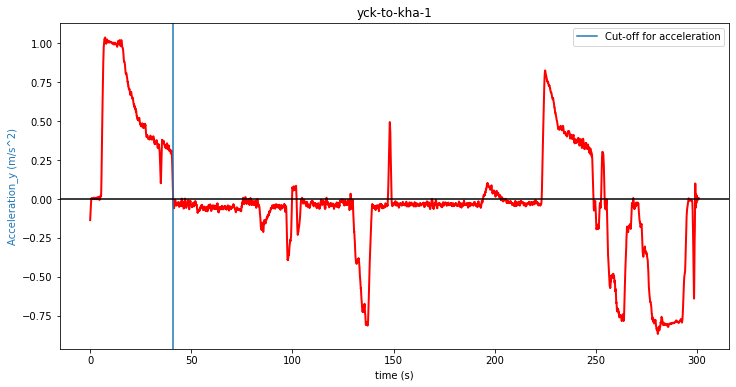

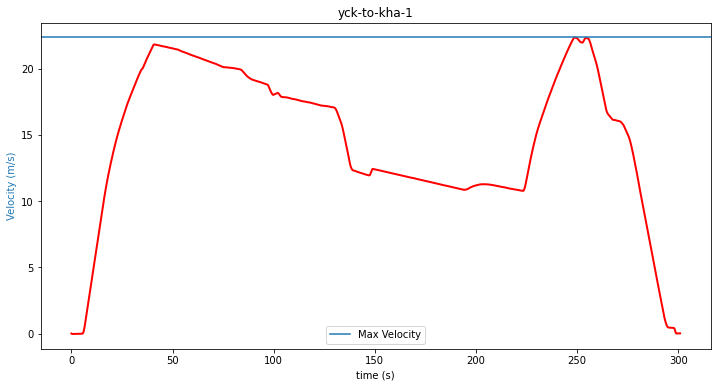

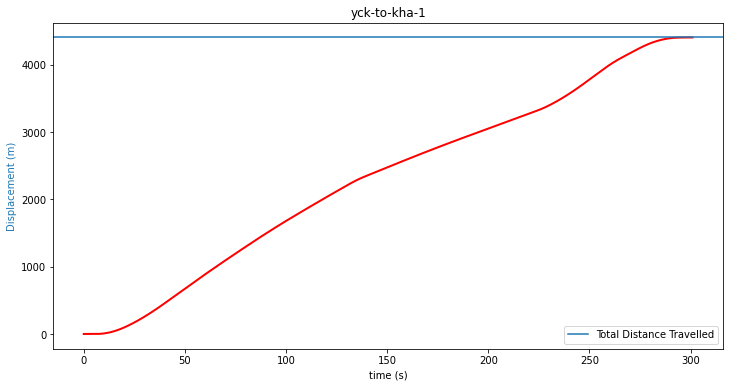

In [26]:
uchoice = 1
uchoice = int(input("Enter [1] to start and [0] to exit: "))
while (uchoice == 1):
    main()
    uchoice = int(input("Enter [1] to start and [0] to exit: "))